# Introduction


We'll be using OpenAI's embeddings for this course so make sure that you've set up a `OPENAI_API_KEY` variable in your shell so that you can run the commands easily out of the box.

Before starting this part, make sure that you have ran the `setup.py` file so that we have a lancedb db that is populated with the first 100 rows of the ms-marco dataset.

**Depending on the internet, this might take a while so do make sure that you have completed this step before the workshop**


# Systematically Improve Your RAG

In this portion, we'll learn how to make data driven decisions using a set of metrics that we can take advantage of to quickly compare different implementations/systems as well as to diagnose potential problems with our RAG application


In [2]:
from lib.data import get_labels
from lib.query import full_text_search, semantic_search, hybrid_search
from lib.eval import score
from lib.models import EmbeddedPassage
from lib.db import get_table
import pandas as pd
import lancedb
from tabulate import tabulate


db = lancedb.connect("../lance")

candidates = {
    "Semantic Search": semantic_search,
    "Full Text Search": full_text_search,
    "Hybrid Search": hybrid_search,
}

test_data = get_labels("../data/queries_single_label.jsonl")[:10]
table = get_table(db, "ms_marco", EmbeddedPassage)

# Run test_data against candidates
results = {}

for candidate, search_fn in candidates.items():
    search_results = search_fn(table, test_data, 25)
    evaluation_metrics = [
        score(retrieved_chunk_ids, query["selected_chunk_id"])
        for retrieved_chunk_ids, query in zip(search_results, test_data)
    ]
    results[candidate] = pd.DataFrame(evaluation_metrics).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.90it/s]


In [3]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(results)

# Print the table
print(tabulate(df.round(2), headers="keys", tablefmt="grid"))

+-----------+-------------------+--------------------+-----------------+
|           |   Semantic Search |   Full Text Search |   Hybrid Search |
+===========+===================+====================+=================+
| mrr@3     |               0.5 |               0.25 |            0.38 |
+-----------+-------------------+--------------------+-----------------+
| mrr@5     |               0.5 |               0.34 |            0.46 |
+-----------+-------------------+--------------------+-----------------+
| mrr@10    |               0.5 |               0.36 |            0.46 |
+-----------+-------------------+--------------------+-----------------+
| mrr@15    |               0.5 |               0.37 |            0.46 |
+-----------+-------------------+--------------------+-----------------+
| mrr@25    |               0.5 |               0.37 |            0.46 |
+-----------+-------------------+--------------------+-----------------+
| recall@3  |               1   |               0.4

# Data Ingestion

Let's start by looking how we can ingest some data


## LanceDB


In this section, we'll be showing you can create a lancedb database, define a new table based off a Pydantic Schema, ingest some data AND perform semantic search and full text search in under 40 lines of code.


In [35]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
import numpy as np

# Connect to the database
db = lancedb.connect("./lance-db")

# Configure our Database Schema
func = get_registry().get("openai").create(name="text-embedding-3-small")


class Entry(LanceModel):
    vector: Vector(func.ndims()) = func.VectorField(default=None)
    text: str = func.SourceField()


table = db.create_table("sample_table", schema=Entry, mode="overwrite")

# Ingest data into our database
sample_data = [
    "The Capital of France is Paris",
    "How long do you need for sydney and surrounding areas",
    "Twitter is a popular web application",
]

table.add([Entry(text=text) for text in sample_data])

table.create_fts_index("text", replace=True)

# Vector Search
results = table.search(np.random.random((1536))).limit(10).to_list()

for result in results:
    print(
        f"(Semantic) text: {result['text']}, vector: {result['vector'][:2]}, distance: {round(result['_distance'],3)}\n"
    )

# Vector Search
results = table.search("What's a good place to visit in France?").limit(10).to_list()

for result in results:
    print(
        f"(Full Text Search) text: {result['text']}, vector: {result['vector'][:2]}, distance: {round(result['_distance'],3)}\n"
    )

[2024-06-10T01:18:23Z WARN  lance::dataset] No existing dataset at /Users/ivanleo/Documents/rag-ws/notebooks/lance-db/sample_table.lance, it will be created


(Semantic) text: The Capital of France is Paris, vector: [0.026060976088047028, 0.020672272890806198], distance: 504.826

(Semantic) text: Twitter is a popular web application, vector: [0.004910335876047611, -0.04718632996082306], distance: 506.344

(Semantic) text: How long do you need for sydney and surrounding areas, vector: [0.009041019715368748, 0.02217705175280571], distance: 507.425

(Full Text Search) text: The Capital of France is Paris, vector: [0.026060976088047028, 0.020672272890806198], distance: 0.892

(Full Text Search) text: How long do you need for sydney and surrounding areas, vector: [0.009041019715368748, 0.02217705175280571], distance: 1.605

(Full Text Search) text: Twitter is a popular web application, vector: [0.004910335876047611, -0.04718632996082306], distance: 1.806



In [28]:
table.to_pandas()

,vector,text
0,"[0.026060976, 0.020672273, 0.017380906, 0.0145...",The Capital of France is Paris
1,"[0.00904102, 0.022177052, 0.06920571, 0.011817...",How long do you need for sydney and surroundin...
2,"[0.004910336, -0.04718633, -0.018725358, 0.030...",Twitter is a popular web application


### Search

What is Full Text Search, Semantic Search and Hybrid Search? Why would we prefer one over the other?


#### Full Text Search

We take a bunch of sentences, process them into some searchable form and then that allows us to find sentences/documents which are closest to a user query.

**We are doing the search on the whole sentence, or some tokens generated from the text itself**


In [6]:
# List of sample sentences to choose from
sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "All good things come to those who wait.",
    "She sells sea shells by the sea shore.",
    "He ran out of money, so he had to stop playing poker.",
    "They got there early, and they got really good seats.",
    "There were white out conditions in the town; subsequently, the roads were impassable.",
    "The sky is clear; the stars are twinkling.",
    "The book is in front of the table.",
    "A song can make or ruin a person’s day if they let it get to them.",
]


def search_sentences(query):
    """Simple full text search in predefined sentences"""
    results = [sentence for sentence in sentences if query.lower() in sentence.lower()]
    return results


# Example usage
query = "Sea Shells"
found_sentences = search_sentences(query)
print("Search results for query '{}':".format(query))
for sentence in found_sentences:
    print(f">> {sentence}")

Search results for query 'Sea Shells':
>> She sells sea shells by the sea shore.


#### Semantic Search

To do Semantic Search, we need a function that converts each sentence into a list of numbers known as a vector. Each number in this list has some semantic meaning, so two lists that have numbers that are closer are considered to be semantically similarly ( have the same meaning )

We take our bunch of sentences, convert them to these list of numbers and store them somewhere. Whenever we have a user query, we then convert it to a vector using the same function and find the vector that's the most similar


In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define some sample vectors
vectors = np.array([[1, 0, 0.5], [0, 1, 0.5], [0.5, 0.5, 0], [0, 0, 1]])


# Define a simple function to perform vector search
def vector_search(query_vector):
    """Perform a cosine similarity search between the query vector and predefined vectors"""
    similarities = cosine_similarity([query_vector], vectors)
    return similarities[0]


# Example usage
query_vector = [0.2, 0.1, 0.7]
similarities = vector_search(query_vector)

print(f"Source >> {query_vector}")
print("==========")

for similarity, vector in zip(similarities, vectors):
    formatted_vector = ", ".join(f"{num:.2f}" for num in vector)
    print(f"[{formatted_vector}] - {round(similarity,3)}")

Source >> [0.2, 0.1, 0.7]
[1.00, 0.00, 0.50] - 0.669
[0.00, 1.00, 0.50] - 0.548
[0.50, 0.50, 0.00] - 0.289
[0.00, 0.00, 1.00] - 0.953


#### Why can't we just use Semantic Search - aren't embeddings all you need?

Each search function has its own unique advantage

- Semantic Search helps to find similar sentences without considering just keyword match
- Text search helps us to identify entries that are using similar accronyms or are making references to specific people/places that semantic search might not catch

Using a variety of search functions helps us to cast a wider net and have a higher chance of finding the entries we want.


#### Data Validation

Why bother using Pydantic?

- Data Validation that works out of the box with Vanilla Python
- Insane Performance with the rust rewrite
- Easy to customise and used by thousands of companies ( ~ 70M downloads per month for a reason )


In [18]:
from datetime import datetime

from pydantic import BaseModel, PositiveInt


class User(BaseModel):
    id: int
    name: str = "John Doe"
    signup_ts: datetime | None
    tastes: dict[str, PositiveInt]


external_data = {
    "id": 123,
    "signup_ts": "2019-06-01 12:22",
    "tastes": {
        "wine": 9,
        b"cheese": 7,
        "cabbage": "1",
    },
}

user = User(**external_data)

print(user.id)
print(user.model_dump())

123
{'id': 123, 'name': 'John Doe', 'signup_ts': datetime.datetime(2019, 6, 1, 12, 22), 'tastes': {'wine': 9, 'cheese': 7, 'cabbage': 1}}


## Exercises

Now that we've seen how easy it is to get started with LanceDB, we can start focusing on some of the most common problems that we'd face when ingesting data

1. How do I store metadata?
2. How can I compute some derived fields from my text chunks
3. How does filtering of results work?
4. How can I do deduplication on my data so that I don't have duplicate chunked text

In the next few examples, we'll show you guys how to perform these basic operations


### Setup

Run this command before proceeding with the exercises. The exercises should be done in order


In [31]:
import json

with open("../data/tools.json", "r") as file:
    data = json.loads(file.read())

In [32]:
data[:2]

[{'name': 'Hammer',
  'description': 'A tool with a heavy metal head mounted at right angles at the end of a handle, used for jobs such as breaking things and driving in nails.',
  'category': 'Hand Tool'},
 {'name': 'Screwdriver',
  'description': 'A tool with a flattened, cross-shaped, or star-shaped tip that fits into the head of a screw to turn it.',
  'category': 'Hand Tool'}]

In [33]:
db = lancedb.connect("./lance-db")

# Delete all tables in db
for table in db.table_names():
    db.drop_table(table)

### Adding metadata

Try to create table which has information on the name, description and category of the item. Make sure to also embed the description using the `OpenAI` embedding function text-embedding-3-small model


In [26]:
# Create the Pydantic Schema

func = get_registry().get("openai").create(name="text-embedding-3-small")


class Tool(LanceModel):
    vector: Vector(func.ndims()) = func.VectorField()
    description: str = func.SourceField()
    name: str
    category: str


tool_table = db.create_table("tool_v1", schema=Tool, mode="overwrite")

[2024-05-28T03:11:07Z WARN  lance::dataset] No existing dataset at /Users/ivanleo/Documents/rag-ws/notebooks/lance-db/tool_v1.lance, it will be created


In [27]:
tool_table.add(data)

In [28]:
tool_table.to_pandas()

,vector,description,name,category
0,"[0.02942855, 0.047012717, 0.004617972, -0.0125...",A tool with a heavy metal head mounted at righ...,Hammer,Hand Tool
1,"[0.018697312, 0.015099513, -0.047086194, -0.01...","A tool with a flattened, cross-shaped, or star...",Screwdriver,Hand Tool
2,"[-0.03568479, 0.013477032, 0.0101103475, -0.01...",A power tool fitted with a cutting tool attach...,Electric Drill,Power Tool
3,"[0.02803261, 0.024098208, -0.026885075, -0.021...","A tool used for gripping and turning nuts, bol...",Wrench,Hand Tool
4,"[0.02052933, 0.014397344, -0.034926675, -0.013...","A hand tool used to hold objects firmly, possi...",Pliers,Hand Tool
5,"[-0.00037332025, 0.033678483, -0.03620599, -0....",A power-saw using a toothed or abrasive disc o...,Circular Saw,Power Tool
6,"[0.020676186, 0.032748703, 0.0079361405, -0.01...",A flexible ruler used to measure size or dista...,Tape Measure,Measuring Tool
7,"[0.06171664, 0.04006746, -0.0073134657, -0.004...",A tool with a characteristically shaped cuttin...,Chisel,Hand Tool
8,"[-0.024902405, 0.054924037, 0.0053345207, -0.0...",An instrument designed to indicate whether a s...,Level,Measuring Tool
9,"[0.014727382, 0.035678905, -0.026631918, -0.03...",A power tool used for cutting arbitrary curves...,Jigsaw,Power Tool


### Computing a field

Let's now try to compute a chunk_id which identifies a unique description and name using the `hashlib` library in python


In [29]:
# Create the Pydantic Schema

func = get_registry().get("openai").create(name="text-embedding-3-small")


class Tool(LanceModel):
    vector: Vector(func.ndims()) = func.VectorField()
    description: str = func.SourceField()
    name: str
    category: str
    tool_id: str


tool_table = db.create_table("tool_v2", schema=Tool, mode="overwrite")

[2024-05-28T03:11:08Z WARN  lance::dataset] No existing dataset at /Users/ivanleo/Documents/rag-ws/notebooks/lance-db/tool_v2.lance, it will be created


In [30]:
import hashlib

encoded_chunks = []
for row in data:
    name_and_description = f"{row['description']}-{row['name']}"
    tool_id = hashlib.md5(name_and_description.encode()).hexdigest()
    encoded_chunks.append({**row, "tool_id": tool_id})

tool_table.add(encoded_chunks)
tool_table.to_pandas()[:10]

,vector,description,name,category,tool_id
0,"[0.029243259, 0.046320148, 0.0031912285, -0.00...",A tool with a heavy metal head mounted at righ...,Hammer,Hand Tool,5127eb88579d6565b794833acf0eff6e
1,"[0.018722245, 0.01513522, -0.047092352, -0.010...","A tool with a flattened, cross-shaped, or star...",Screwdriver,Hand Tool,18ffc6ead466b6e270e8a970544510d3
2,"[-0.03569433, 0.013480635, 0.010113051, -0.019...",A power tool fitted with a cutting tool attach...,Electric Drill,Power Tool,ad1d1aac2c439006635c48d6969d2a8f
3,"[0.028033728, 0.02412259, -0.026932988, -0.021...","A tool used for gripping and turning nuts, bol...",Wrench,Hand Tool,bbf94b44b5866f023b2b8b5491657dd3
4,"[0.02175587, 0.013911997, -0.03692618, -0.0119...","A hand tool used to hold objects firmly, possi...",Pliers,Hand Tool,36d03bc35bdddd89da298675e5c0cd73
5,"[-0.0005456097, 0.033061855, -0.03701373, -0.0...",A power-saw using a toothed or abrasive disc o...,Circular Saw,Power Tool,61051798477a715f7e2e09df8880a8ee
6,"[0.020711862, 0.03277381, 0.007930988, -0.0128...",A flexible ruler used to measure size or dista...,Tape Measure,Measuring Tool,8bd1313982c2bd9313f1ac304ac43f8b
7,"[0.061667863, 0.0399984, -0.0072744344, -0.004...",A tool with a characteristically shaped cuttin...,Chisel,Hand Tool,d65a66bc9595fa8a1247bcdcbe5a0a37
8,"[-0.024902405, 0.054924037, 0.0053345207, -0.0...",An instrument designed to indicate whether a s...,Level,Measuring Tool,356a50889baebb01c83c2b33eba1187c
9,"[0.014716265, 0.03568, -0.026632737, -0.033990...",A power tool used for cutting arbitrary curves...,Jigsaw,Power Tool,dda7672a25896af487fef054e3775f2a


### Filtering


Now that we've indexed our data inside the field, let's try to retrieve all of the tools which have the category Hand Tool (Note here that we have prefilter=True which allows us to ensure we get the number of elements that we want in the end


In [31]:
%%time
tool_table = db.open_table("tool_v2")
tool_table.search().select(["name", "description", "category"]).where(
    "category='Hand Tool'", prefilter=True
).to_pandas()

CPU times: user 4.81 ms, sys: 3.5 ms, total: 8.31 ms
Wall time: 4.81 ms


,name,description,category
0,Hammer,A tool with a heavy metal head mounted at righ...,Hand Tool
1,Screwdriver,"A tool with a flattened, cross-shaped, or star...",Hand Tool
2,Wrench,"A tool used for gripping and turning nuts, bol...",Hand Tool
3,Pliers,"A hand tool used to hold objects firmly, possi...",Hand Tool
4,Chisel,A tool with a characteristically shaped cuttin...,Hand Tool
5,Allen Wrench,A tool used to drive bolts and screws with hex...,Hand Tool
6,Socket Wrench,"A wrench with a socket attached at one end, us...",Hand Tool
7,Hacksaw,"A fine-toothed saw, originally and mainly made...",Hand Tool
8,Soldering Iron,"A hand tool used in soldering, which supplies ...",Hand Tool


Now that we've indexed a single column, let's try now returning rows that have the `Measuring Tool` and `Hand Tool` category


In [32]:
%%time
tool_table = db.open_table("tool_v2")
tool_table.search().select(["name", "description", "category"]).where(
    "category IN ('Hand Tool','Measuring Tool')", prefilter=True
).to_pandas()

CPU times: user 5.98 ms, sys: 4.15 ms, total: 10.1 ms
Wall time: 8.41 ms


,name,description,category
0,Hammer,A tool with a heavy metal head mounted at righ...,Hand Tool
1,Screwdriver,"A tool with a flattened, cross-shaped, or star...",Hand Tool
2,Wrench,"A tool used for gripping and turning nuts, bol...",Hand Tool
3,Pliers,"A hand tool used to hold objects firmly, possi...",Hand Tool
4,Tape Measure,A flexible ruler used to measure size or dista...,Measuring Tool
5,Chisel,A tool with a characteristically shaped cuttin...,Hand Tool
6,Level,An instrument designed to indicate whether a s...,Measuring Tool
7,Allen Wrench,A tool used to drive bolts and screws with hex...,Hand Tool
8,Socket Wrench,"A wrench with a socket attached at one end, us...",Hand Tool
9,Hacksaw,"A fine-toothed saw, originally and mainly made...",Hand Tool


### Deduplication

Now that we've ingested the data, we need to make sure we don't have any deduplication of data. To do so, we'll use a second set of tools in `tool_2.json` which has some overlapping entries.


In [33]:
with open("./tools_2.json", "r") as file:
    data_2 = json.loads(file.read())

In [34]:
tool_table.count_rows(), len(data_2)

(16, 7)

In [35]:
tool_table = db.open_table("tool_v1")
tool_table.add(data_2)
tool_table.count_rows()

23

In [36]:
tool_table = db.open_table("tool_v1")
tool_table.add(data_2)
tool_table.count_rows()

30

In [37]:
import hashlib

encoded_chunks = []
for row in data_2:
    name_and_description = f"{row['description']}-{row['name']}"
    chunk_id = hashlib.md5(name_and_description.encode()).hexdigest()
    encoded_chunks.append({**row, "chunk_id": chunk_id})

In [38]:
# Create the Pydantic Schema

func = get_registry().get("openai").create(name="text-embedding-3-small")


class Tool(LanceModel):
    vector: Vector(func.ndims()) = func.VectorField()
    description: str = func.SourceField()
    name: str
    category: str
    chunk_id: str


tool_table = db.create_table("tool_v2", schema=Tool, mode="overwrite")

encoded_chunks = []
for row in data:
    name_and_description = f"{row['description']}-{row['name']}"
    chunk_id = hashlib.md5(name_and_description.encode()).hexdigest()
    encoded_chunks.append({**row, "chunk_id": chunk_id})


def get_duplicate_chunk_ids(encoded_chunks):
    tool_table = db.open_table("tool_v2")
    ids = [item["chunk_id"] for item in encoded_chunks]

    formatted_filter = ", ".join([f"'{id}'" for id in ids])
    return set(
        tool_table.to_lance()
        .to_table(filter=f"chunk_id in ({formatted_filter})", columns=["chunk_id"])
        .to_pandas()["chunk_id"]
    )


def filter_duplicate_chunks(encoded_chunks, duplicate_ids):
    return [item for item in encoded_chunks if item["chunk_id"] not in duplicate_ids]


duplicate_ids = get_duplicate_chunk_ids(encoded_chunks)
filtered_chunks = filter_duplicate_chunks(encoded_chunks, duplicate_ids)

if filtered_chunks:
    tool_table.add(filtered_chunks)
tool_table.count_rows()

16

Before we proceed, let's clean up the database that we used for this section and remove it from our computer


In [39]:
import shutil

shutil.rmtree("./lance-db")

**Summary** : LanceDB provides an easy way to have FTS ( as a simple baseline ) and embedding search. It also handles batching and provides other functionality such as integrations with duckdb, arrow table and filtering out of the box.


# Metrics

The metrics you capture are specific to the use case that you have. In this notebook we'll walk through 3-4 different potential example use cases and why you might want different metrics at each step.


## At K

We need to report the size of the list of elements that we compute our metrics for. This is known as the `at k` value. For instance, if we calculated the precision of a list of 5 elements, we would say that our `precision@5` metric is `x`.

This is important because k is often constrained by a business outcome and can help us determine how well our solution works

Eg.

- `k=5` : We'd like to display some recomended items based of a user query (Eg. Help me plan out a dinner with Jonathan next week -> Display 5 possible actions)
- `k=10` : We have a small carousel with recomended items for a user to buy
- `k=25` : We're using a re-ranker, is it filtering out the irrelevant chunks from the relevant chunks well?
- `k=50` : We have a pipeline that fetches information for a model to respond with, are we fetching all relevant bits of information


## Quick Note

Note that many of the metrics we'll show below work with binary labels - this means that we only have information on whether they are relevant or not. This is sufficient for most RAG applications since the model itself will be able to determine the relevance of the chunk relative to the user's query.

As models improve, this will become less of a problem.


## Reciprocal Rank


Lists in python are going to be 0 indexed. The first element has a index of 0, the second has an index of 1 and so on.

If our list is `[1,2,3,4]`, then

- Index 0 : 1
- Index 1 : 2
- Index 2 : 3
- Index 3 : 4


If we're using LLMs to generate search queries to identify potential actions that a user might want us to take, then we definitely want to make sure that we surface relevant results as early as possible. In other words, we want to make sure our index is as close to 0 as possible.

> Which is a better result among the two lists of retrieved songs below? ( Note that 2 is the answer we want )

- [0,1,2,3,4]
- [0,1,3,4,2]

Obviously if we're suggesting actions to the user, we want the first relevant action to be listed as early as possible! Therefore we'd prefer 1 over 2 in the example above because 2 is ordered earlier in the first case.

A metric that works well for this is the Reciprocal Rank (RR).

$$
\frac{1}{\text{Index of first relevant item + 1}}
$$

We add 1 here so that we don't get a zero division error ( Since indexes start from 0 )


In [38]:
def rr(results, label):
    return round(1 / (results.index(label) + 1), 2) if label in results else 0


rr([0, 1, 2, 3, 4], 2), rr([0, 1, 3, 4, 2], 2)

(0.33, 0.2)

This is an aggressive metric and once we get to an position of > 10, the value doesn't change much anymore. Most of the big changes happen at indexes < 10.


In [40]:
def get_rr_at_index(desired_index, length=20):
    return rr([0 if i != desired_index else 1 for i in range(length)], 1)


max_itrs = 10
for i in range(max_itrs):
    curr_rr = get_rr_at_index(i)
    decrease = get_rr_at_index(i + 1) - get_rr_at_index(i) if i < max_itrs - 1 else 0
    decrease_string = f" ---|(-{decrease:.2f})" if i < max_itrs - 1 else ""
    print(f"{i:2}| {' '*(7*i)}{curr_rr:.2f}{decrease_string}")
    if i < max_itrs - 1:
        print("↓".rjust(7 * (i + 1) + 6))
    prev_rr = curr_rr

 0| 1.00 ---|(--0.50)
            ↓
 1|        0.50 ---|(--0.17)
                   ↓
 2|               0.33 ---|(--0.08)
                          ↓
 3|                      0.25 ---|(--0.05)
                                 ↓
 4|                             0.20 ---|(--0.03)
                                        ↓
 5|                                    0.17 ---|(--0.03)
                                               ↓
 6|                                           0.14 ---|(--0.02)
                                                      ↓
 7|                                                  0.12 ---|(--0.01)
                                                             ↓
 8|                                                         0.11 ---|(--0.01)
                                                                    ↓
 9|                                                                0.10


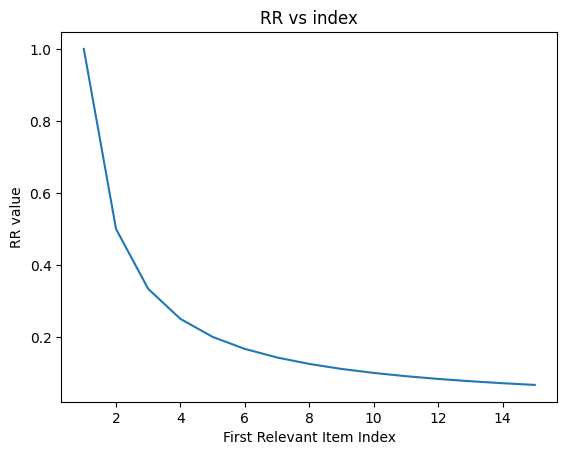

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 15, 15)
y = 1 / x

plt.plot(x, y)
plt.xlabel("First Relevant Item Index")
plt.ylabel("RR value")
plt.title("RR vs index")
plt.show()

In [47]:
def rr_multi(results, labels):
    return max(
        [
            round(1 / (results.index(label) + 1), 2) if label in results else 0
            for label in labels
        ]
    )


rr_multi([0, 1, 2, 3, 5], [2, 4]), rr_multi([0, 1, 3, 4, 2], [2, 5])

(0.33, 0.2)

When we have a group of different items and we take the average rr, we get the Mean Reciprocal Rank (MRR) which tells us the average position of the first relevant item in our retrieved results


## Recall

Imagine that we're trying to do some Retrieval Augmented Generation and we're not getting good results - some of our vibe checks are failing. How can we now diagnose the issue and determine if it's our retrieval pipeline that's causing the issue?

Well, recall is a great place to start!


In [48]:
result_1 = [1, 2, 3, 4, 5]
result_2 = [5, 2, 7, 8, 9]

relevant_chunks = [4, 5]

> Why care about the number of retrieved relevant documents? Aren't we going to have a lot of irrelevant documents? => We care about the total number of retrieved relevant documents because we are confident that our model is able to sift through the provided sources. As model capabilities improve, this is quite a valid assumption ( See [Needle In A Haystack](https://arize.com/blog-course/the-needle-in-a-haystack-test-evaluating-the-performance-of-llm-rag-systems/) test )

We're trying to ask a single question when we look at Recall - How many of my relevant documents were retrieved? It can be calculated by taking

$$
\frac{\text{Number of Relevant Documents retrieved}}{\text{Total Number of relevant documents}}
$$


In [49]:
def recall(results, relevant_chunks):
    return sum([1 if chunk in results else 0 for chunk in relevant_chunks]) / len(
        relevant_chunks
    )


recall(result_1, relevant_chunks), recall(result_2, relevant_chunks)

(1.0, 0.5)

### What affects recall?

#### Number of irrelevant items?

Recall isn't affected by the number of irrelevant items


In [52]:
result_1 = [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
result_2 = [1, 2, 3]

relevant_chunks = [1, 2, 4, 10]

# Which has a better recall?

(
    recall(result_1, relevant_chunks),
    recall(result_2, relevant_chunks),
)  # Recall is the same!

(0.5, 0.5)

#### Ordering of Elements?

Is Recall affected by the order of the elements? What happens if we jumble up the order of these items each time so that the elements are preserved BUT the ordering is not?


In [53]:
r1 = [0, 0, 0, 1, 2, 3, 4]
r2 = [0, 0, 0, 1, 2, 3, 0]
r3 = [0, 0, 0, 1, 2, 0, 0]
r4 = [0, 0, 0, 1, 0, 0, 0]
r5 = [0, 0, 0, 0, 0, 0, 0]

relevant_chunks = [1, 2, 3, 4]

retrieved_results = [r1, r2, r3, r4, r5]

for retrieved_result in retrieved_results:
    print(f"{retrieved_result} -> Recall: {recall(retrieved_result,relevant_chunks)}")

[0, 0, 0, 1, 2, 3, 4] -> Recall: 1.0
[0, 0, 0, 1, 2, 3, 0] -> Recall: 0.75
[0, 0, 0, 1, 2, 0, 0] -> Recall: 0.5
[0, 0, 0, 1, 0, 0, 0] -> Recall: 0.25
[0, 0, 0, 0, 0, 0, 0] -> Recall: 0.0


In [61]:
import random

r1 = [0, 0, 0, 1, 2, 3, 4]
r2 = [0, 0, 0, 1, 2, 3, 0]
r3 = [0, 0, 0, 1, 2, 0, 0]
r4 = [0, 0, 0, 1, 0, 0, 0]
r5 = [0, 0, 0, 0, 0, 0, 0]

relevant_chunks = [1, 2, 3, 4]

retrieved_results = [r1, r2, r3, r4, r5]

for retrieved_result in retrieved_results:
    random.shuffle(retrieved_result)
    print(f"{retrieved_result} -> Recall: {recall(retrieved_result,relevant_chunks)}")

[0, 0, 1, 4, 3, 2, 0] -> Recall: 1.0
[1, 0, 0, 0, 2, 0, 3] -> Recall: 0.75
[0, 0, 1, 0, 0, 2, 0] -> Recall: 0.5
[0, 0, 0, 0, 0, 0, 1] -> Recall: 0.25
[0, 0, 0, 0, 0, 0, 0] -> Recall: 0.0


Therefore we can conclude that recall is **unaffected by the ordering of the items** and **unaffected by the number of irrelevant items**. It only cares about **the proportions of the relevant items that were retrieved**!


## Precision

Say we're coding a new Agent which has access to 1000s of tools, how can we ensure we're giving our agent the right tools each time?

For instance, say the user asks us a question of "Help me find a time to meet with Daniel for dinner next week" and we have the tools below

Make a Calendar Appointment
View Calendar
Order a Coffee
Send an Email
Get the Weather
Make a flight booking
What are the most relevant tools that our model should return?


In [62]:
tools = [
    "make_appointment",
    "view_calendar",
    "order_coffee",
    "send_email",
    "get_weather",
    "make_flight_booking",
]

candidate_1 = ["order_coffee", "make_flight_booking", "get_weather"]
candidate_2 = ["view_calendar", "make_flight_booking", "get_weather"]
candidate_3 = ["view_calendar", "make_appointment", "send_email"]

relevant_tools = ["view_calendar", "make_appointment", "send_email"]

How can we evaluate candidate_1, candidate_2 and candidate_3 so that we are able to rank them in terms of quality?

We can use precision here to evaluate our models


In [64]:
def precision(retrieved_items, relevant_items):
    return round(
        sum([1 if item in relevant_items else 0 for item in retrieved_items])
        / len(retrieved_items),
        2,
    )


evaluated_items = [candidate_1, candidate_2, candidate_3]

for item in evaluated_items:
    print(f"{item} - {precision(item,relevant_tools)}")

['order_coffee', 'make_flight_booking', 'get_weather'] - 0.0
['view_calendar', 'make_flight_booking', 'get_weather'] - 0.33
['view_calendar', 'make_appointment', 'send_email'] - 1.0


### What affects precision?

#### Ordering of Elements?

What happens if we randomly reorder the items


In [73]:
import random

evaluated_items = [candidate_1, candidate_2, candidate_3]

for item in evaluated_items:
    random.shuffle(item)
    print(f"{item} - {precision(item,relevant_tools)}")

['order_coffee', 'make_flight_booking', 'get_weather'] - 0.0
['make_flight_booking', 'view_calendar', 'get_weather'] - 0.33
['make_appointment', 'view_calendar', 'send_email'] - 1.0


#### Number of Irrelevant Items?

Is precision going to be affected by the number of irrelevant items?


In [74]:
result_1 = [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
result_2 = [1, 2, 3]

relevant_chunks = [1, 2, 4, 10]

# Which has a better recall?

(
    precision(result_1, relevant_chunks),
    precision(result_2, relevant_chunks),
)  # Precision is badly affected

(0.15, 0.67)

Therefore we can conclude that recall is **unaffected by the ordering of the items** and **unaffected by the number of irrelevant items**. It only cares about **the proportions of the relevant items that were retrieved**!


## Precision vs Recall Tradeoff

Choosing to optimize precision often comes at the cost of recall and vice versa. But how does this play out?

| Recall | Precision | Interpretation                                                                 |
| ------ | --------- | ------------------------------------------------------------------------------ |
| High   | Low       | We have a shot if the LLM is robust to noise, might run out of context length. |
| Low    | High      | We might give an incomplete answer, did not get all the content                |
| High   | High      | If we do poorly here, it's because our generation prompt is...bad.             |
| Low    | Low       | We're not doing well at all, nuke the system!                                  |


In [75]:
# Eg. I want super high recall

result_1 = [
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    2,
]  # Hope our LLM is robust to noise and has enough context

# Recall High, Precision Low

# Eg. I want super high precision

result_1 = [
    1,
    0,
    0,
]  # Missed out the 2 which was very far back ( Eg. incomplete answers )

# Eg. I miraculously have high precision and recall

result_1 = [1, 2]

# Eg. Low

result_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating Our Data

Let's see an example of how we can evaluate our data using the ms-marco dataset with real user queries


In [114]:
from itertools import product
from lib.eval import calculate_reciprocal_rank, calculate_recall, score

SIZES = [3, 5, 10, 15, 25]


metrics = {"mrr": calculate_reciprocal_rank, "recall": calculate_recall}

In [116]:
from tqdm import tqdm
import pandas as pd

db = lancedb.connect("../lance")
table = db.open_table("ms_marco")


def load_jsonl_file(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            json_obj = json.loads(line.strip())
            data.append(json_obj)
    return data


def get_k_relevant_chunk_ids(table, query, number):
    return [
        item["chunk_id"]
        for item in table.search(query, query_type="fts").limit(number).to_list()
    ]


def score(preds, label: str | list[str]):
    return {
        f"{fn_name}@{size}": round(
            metrics[fn_name](preds[:size], [label] if type(label) == str else label),
            3,
        )
        for fn_name, size in product(metrics.keys(), SIZES)
    }


import os

data = load_jsonl_file(os.path.abspath("../data/queries_single_label.jsonl"))

scores = []
for item in tqdm(data):
    query = item["query"]
    selected_chunk = item["selected_chunk_id"]
    retrieved_chunk_ids = get_k_relevant_chunk_ids(table, query, max(SIZES))
    scores.append(score(retrieved_chunk_ids, selected_chunk))

df = pd.DataFrame(scores)
df.mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 44.30it/s]


mrr@3        0.347763
mrr@5        0.395251
mrr@10       0.423288
mrr@15       0.425776
mrr@25       0.426694
recall@3     0.497717
recall@5     0.707763
recall@10    0.904110
recall@15    0.936073
recall@25    0.954338
dtype: float64

In [118]:
from tqdm import tqdm
import pandas as pd

db = lancedb.connect("../lance")
table = db.open_table("ms_marco")


def load_jsonl_file(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            json_obj = json.loads(line.strip())
            data.append(json_obj)
    return data


def get_k_relevant_chunk_ids(table, query, number):
    return [
        item["chunk_id"]
        for item in table.search(query, query_type="fts").limit(number).to_list()
    ]


def score(preds, label: str | list[str]):
    return {
        f"{fn_name}@{size}": round(
            metrics[fn_name](preds[:size], [label] if type(label) == str else label),
            3,
        )
        for fn_name, size in product(metrics.keys(), SIZES)
    }


import os

data = load_jsonl_file(os.path.abspath("../data/queries_multi_label.jsonl"))

scores = []
for item in tqdm(data):
    query = item["query"]
    selected_chunk = item["selected_chunk_ids"]
    retrieved_chunk_ids = get_k_relevant_chunk_ids(table, query, max(SIZES))
    scores.append(score(retrieved_chunk_ids, selected_chunk))

df = pd.DataFrame(scores)
df.mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 44.74it/s]


mrr@3        0.380071
mrr@5        0.424459
mrr@10       0.450224
mrr@15       0.452541
mrr@25       0.453311
recall@3     0.497449
recall@5     0.703230
recall@10    0.900510
recall@15    0.933673
recall@25    0.951531
dtype: float64

# Cold Starting

What can we do if we have no user queries and we're just starting out? Well, the easiest way is to use synthethic queries to automatically generate the data to do so!


In [58]:
import instructor
import openai
from pydantic import BaseModel, Field
from tqdm.asyncio import tqdm_asyncio as asyncio

client = instructor.from_openai(openai.AsyncOpenAI())


class QuestionAnswerPair(BaseModel):
    """
    This model represents a pair of a question generated from a text chunk, its corresponding answer,
    and the chain of thought leading to the answer. The chain of thought provides insight into how the answer
    was derived from the question.
    """

    chain_of_thought: str = Field(
        ..., description="The reasoning process leading to the answer."
    )
    question: str = Field(
        ..., description="The generated question from the text chunk."
    )
    answer: str = Field(..., description="The answer to the generated question.")


async def generate_question_batch(text_chunk_batch):
    async def generate_question(text: str):
        question = await client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "system",
                    "content": "You are a world class AI that excels at generating hypothethical search queries. You're about to be given a text snippet and asked to generate a search query which is specific to the specific text chunk that you'll be given. Make sure to use information from the text chunk.",
                },
                {"role": "user", "content": f"Here is the text chunk : {text}"},
            ],
            response_model=QuestionAnswerPair,
            max_retries=3,
        )
        return (question, text)

    coros = [generate_question(item) for item in text_chunk_batch]
    res = await asyncio.gather(*coros)
    return [{"input": item.question, "source": text} for item, text in res]


chunks = [
    "Conversion disorder is a type of somatoform disorder where physical symptoms or signs are present that cannot be explained by a medical condition. Very importantly, unlike factitious disorders and malingering, the symptoms of somatoform disorders are not intentional or under conscious control of the patient",
    "A conifer is a tree or shrub which produces distinctive cones as part of its sexual reproduction. These woody plants are classified among the gymnosperms, and they have a wide variety of uses, from trapping carbon in the environment to providing resins which can be used in the production of solvents. Several features beyond the cones set conifers apart from other types of woody plants. A conifer is typically evergreen, although some individuals are deciduous, and almost all conifers have needle or scale-like leaves",
    "Known by multiple common names, such as humbug damselfish, three-striped damselfish and white-tailed damselfish, Dascyllus aruanus is a feisty little fish that adapts well to aquarium life. Three-striped damselfish can be pugnacious and are better introduced at the latter stages of setting up a marine fish community. Remove as many of the three-striped damselfish fry as you want to try and raise to a rearing aquarium, with an absence of adult fish and invertebrates that might look upon the young fish as tasty morsels for the taking. Dascyllus aruanus is a worthy first-time breeding project for up-and-coming marine aquarists",
]

questions = await generate_question_batch(chunks)
questions

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


[{'input': 'What is conversion disorder and how does it differ from factitious disorders and malingering?',
  'source': 'Conversion disorder is a type of somatoform disorder where physical symptoms or signs are present that cannot be explained by a medical condition. Very importantly, unlike factitious disorders and malingering, the symptoms of somatoform disorders are not intentional or under conscious control of the patient'},
 {'input': 'What are the key features that differentiate conifers from other types of woody plants?',
  'source': 'A conifer is a tree or shrub which produces distinctive cones as part of its sexual reproduction. These woody plants are classified among the gymnosperms, and they have a wide variety of uses, from trapping carbon in the environment to providing resins which can be used in the production of solvents. Several features beyond the cones set conifers apart from other types of woody plants. A conifer is typically evergreen, although some individuals are

In [ ]:
questions[0]["input"]

## Instructor

Instructor is a library that provides structured output validation


In [ ]:
import instructor
from pydantic import BaseModel
from openai import OpenAI


# Define your desired output structure
class UserInfo(BaseModel):
    name: str
    age: int


# Patch the OpenAI client
client = instructor.from_openai(OpenAI())

# Extract structured data from natural language
user_info = client.chat.completions.create(
    model="gpt-3.5-turbo",
    response_model=UserInfo,
    messages=[{"role": "user", "content": "John Doe is 30 years old."}],
)

print(user_info.name)
print(user_info.age)

### Exercises


Now that we've seen what Instructor can do, let's work through a few different exercises to get a better understanding of the library


#### Adding some docstrings

Let's try creating a Pydantic Model that has docstrings and descriptions using the `Field` object.

Modify the original `UserInfo` object to include a docstring and a description of each field


In [59]:
from pydantic import Field

In [60]:
class UserInfo(BaseModel):
    """
    This is a model which represents a single user's information
    """

    name: str = Field(
        ..., description="This is the user's name which we have extracted"
    )
    age: int = Field(..., description="This is the user's age which we have extracted")

In [61]:
UserInfo.model_json_schema()

{'description': "This is a model which represents a single user's information",
 'properties': {'name': {'description': "This is the user's name which we have extracted",
   'title': 'Name',
   'type': 'string'},
  'age': {'description': "This is the user's age which we have extracted",
   'title': 'Age',
   'type': 'integer'}},
 'required': ['name', 'age'],
 'title': 'UserInfo',
 'type': 'object'}

#### Using simple validation

Now that we've seen how to work with simple User Fields, let's start implementing validators.

Validators are simple functions that run on the returned response from OpenAI. Using Validators, we can ensure that we have valid output. To show how a simple validator might work, let's try to implement a simple function which generates three categories given an article title.


In [ ]:
from pydantic import field_validator


class Metadata(BaseModel):
    """
    This is a model which represents a list of categories that we can classify the given article into
    """

    categories: list[str] = Field(
        ...,
        description="This is the list of categories that we can classify the given article into",
    )
    keywords: list[str] = Field(
        ...,
        description="These are some keywords that users might search for when looking for similar articles as the given article.",
    )

    @field_validator("categories")
    def check_categories_length(cls, v):
        if not (3 <= len(v) <= 5):
            raise ValueError(
                "categories must have at least 3 elements and at most 5 elements"
            )
        return v

In [ ]:
metadata = client.chat.completions.create(
    model="gpt-3.5-turbo",
    response_model=Metadata,
    messages=[
        {
            "role": "system",
            "content": "You are a World Class classification Algorithm. You are about to be given an article title to classify. Make sure to return your response in the model provided",
        },
        {
            "role": "user",
            "content": "Give me a sample article title for classification: The Future of Artificial Intelligence in Healthcare",
        },
    ],
)
metadata

#### More Complex Types

We've now seen how to use Pydantic to validate our returned types with instructor. Now let's try a more complex example

Imagine you're trying to do some query parsing and you have a set of given tools

1. Internet Search
2. Database Queries
3. Meeting Scheduler

How might we represent this in a Pydantic Model?


In [71]:
from datetime import datetime
from typing import List, Literal, Union
from pydantic import field_validator
from openai import OpenAI
import instructor

client = instructor.from_openai(OpenAI())


class InternetSearch(BaseModel):
    """
    Model for representing an internet search query.

    """

    id: int = Field(..., description="Unique id of the query")
    search_query: str = Field(
        ...,
        description="This is an internet search query that we will execute to identify relevant information.",
    )
    dependencies: List[int] = Field(
        default_factory=list,
        description="List of sub questions that need to be answered before asking this question",
    )


class CalendarQuery(BaseModel):
    """
    A model that represents
    """

    id: int = Field(..., description="Unique id of the query")
    calendar: Literal["Personal", "Work"] = Field(
        ..., description="The type of calendar (Personal or Work)."
    )
    start_date: str = Field(
        ...,
        description="The earliest date for events that we'd like to fetch for this calendar",
    )
    end_date: str = Field(
        ...,
        description="The latest date for events that we'd like to fetch for this calendar",
    )
    dependencies: List[int] = Field(
        default_factory=list,
        description="List of sub questions that need to be answered before asking this question",
    )

    @field_validator("start_date", "end_date")
    def validate_date_format(cls, value):
        try:
            datetime.strptime(value, "%d-%m")
        except ValueError:
            raise ValueError("Date must be in the format dd-mm")
        return value


class QueryModel(BaseModel):
    """
    A list of actions to execute in order to complete the user's request
    """

    actions: List[Union[InternetSearch, CalendarQuery]] = Field(
        ..., description="A list of actions."
    )


def generate_actions(request: str) -> QueryModel:
    """
    Generate a list of actions to schedule an appointment based on the user's request.
    """
    return client.chat.completions.create(
        model="gpt-4o",
        response_model=QueryModel,
        messages=[
            {
                "role": "system",
                "content": "You are a scheduling assistant capable of breaking down complex user queries into actions to be executed. Do not answer the question but instead return a list of plausible steps in order to get enough information to answer the user's query",
            },
            {
                "role": "assistant",
                "content": "The date today is 27 May 2024, Monday. The user lives in Downtown Toronto and generally likes Japanese Food",
            },
            {"role": "user", "content": request},
        ],
        max_retries=3,
    )


request = "I'd like to grab dinner with Daniel sometime next week. Can you help me find some time in my calendar and some potential dinner spots?"
actions = generate_actions(request)
print(actions)

actions=[CalendarQuery(id=1, calendar='Personal', start_date='03-06', end_date='09-06', dependencies=[]), InternetSearch(id=2, search_query='best Japanese restaurants in Downtown Toronto', dependencies=[])]
